## Load dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Let's take a look at the first training example:

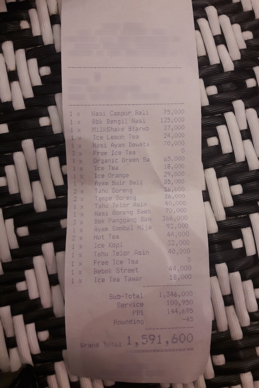

In [3]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [4]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price

## Load model

In [5]:
from peft import LoraConfig
from transformers import BitsAndBytesConfig, Idefics2ForConditionalGeneration
import torch

lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False,
        init_lora_weights="gaussian"
    )
bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
)

model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
model.add_adapter(lora_config)
model.enable_adapters()

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


## Create PyTorch dataset

Here we create a regular PyTorch dataset.


In [6]:
import json
import random
from typing import Any, List, Dict

import torch
from torch.utils.data import Dataset

from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

added_tokens = []


class Idefics2Dataset(Dataset):
    """
    PyTorch Dataset for Idefics2. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt).
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        split: str = "train",
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        image = sample["image"]
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        
        return image, target_sequence

2024-04-30 12:39:37.461173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 12:39:38.252248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
train_dataset = Idefics2Dataset("naver-clova-ix/cord-v2",  split="train", sort_json_key=False)
val_dataset = Idefics2Dataset("naver-clova-ix/cord-v2", split="validation", sort_json_key=False)

You can verify that a token like `</s_unitprice>` was added to the vocabulary of the tokenizer (and the model):

In [8]:
processor.decode([57560])

''

As always, it's very important to verify whether our data is prepared correctly. Let's check the first training example:

In [9]:
train_dataset[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=864x1296>,
 '<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [10]:
from torch.utils.data import DataLoader

image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]


def collate_fn(examples):
    texts = []
    images = []
    answers = []
    for example in examples:
        image, ground_truth = example
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract JSON."},
                    {"type": "image"},
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": ground_truth}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        texts.append(text.strip())
        images.append([image])
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = image_token_id
    batch["labels"] = labels

    batch["images"] = images
    batch["answers"] = answers

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    pixel_attention_mask = batch["pixel_attention_mask"]
    labels = batch["labels"]
    
    return input_ids, attention_mask, pixel_values, pixel_attention_mask, labels, images, answers

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2, shuffle=False, num_workers=4)

## Let's verify a batch

In [11]:
input_ids, attention_mask, pixel_values, pixel_attention_mask, labels, images, answers = next(iter(train_dataloader))

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default clas

In [12]:
print(processor.batch_decode(input_ids))

['<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> User: Extract JSON.<fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image><end_of_utterance> \nAssistant:<s_menu><s_nm>MILK PASTRY ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>CARAMEL PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price></s_menu><s_total><s_total_price>21,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>29,000</s_changeprice></s_total><end_of_utterance>', '<s> User: Extract JSON.<fake_token_around_image>

## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [13]:
import re
from nltk import edit_distance
import numpy as np

import lightning as L


class Idefics2ModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, pixel_attention_mask, labels, images, answers = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                pixel_attention_mask=pixel_attention_mask,
                                labels=labels)
        loss = outputs.loss
        
        self.log("train_loss", loss)
        
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        
        input_ids, attention_mask, pixel_values, pixel_attention_mask, labels, images, answers = batch
        texts = []
        
        # we feed the prompt to the model
        for _ in range(len(answers)):
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Extract JSON."},
                        {"type": "image"},
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=True)
            texts.append(text.strip())
        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")
        generated_ids = model.generate(**inputs, max_new_tokens=64)
        generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
    
        predictions = []
        for seq in generated_texts:
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            answer = answer.replace(self.processor.tokenizer.eos_token, "") 

            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [14]:
config = {"max_epochs": 10,
          "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "num_training_samples_per_epoch": 800,
          "lr": 1e-4,
          "train_batch_sizes": [8],
          "val_batch_sizes": [2],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
          }

model_module = Idefics2ModelPLModule(config, processor, model)

Let's start training!

In [15]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

wandb_logger = WandbLogger(project="Idefics2", name="demo-run-cord")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("nielsr/idefics2-cord-demo",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("nielsr/idefics2-cord)demo",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = L.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/lightning/fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nielsrogge. Use `wandb login --rel

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | Idefics2ForConditionalGeneration | 4.4 B 
-----------------------------------------------------------
23.3 M    Trainable params
4.3 B     Non-trainable params
4.4 B     Total params
17,439.532Total estimated model params size (MB)


Epoch 0:   0%|          | 0/400 [00:00<?, ?it/s] 

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default clas

Epoch 0:  20%|██        | 80/400 [01:02<04:10,  1.28it/s, v_num=wi09]

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
No chat template is set for this tokenizer, falling back to a default clas

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.
/home/niels/python_projects/transformers/src/transformers/generation/utils.py:1542: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and

Prediction: <s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.7002881844380403


/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: <s_nm>S-Ovaltine</s_nm><s_cnt>1</s_cnt><s_price>20,000,000</s_price><s_sub><s_nm>PB1</s_nm><s_price
    Answer: <s_menu><s_nm>S-Ovaltine 50%</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price><s_vatyn>10% Tax Included</s_vatyn></s_menu><s_sub_total><s_subtotal_price>18,181</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.7617801047120419
Prediction: <s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>- Sedang</s_nm><s_cnt>1</s_
    Answer: <s_menu><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_change